# Part1 Assistant Codes
（辅助用的代码，主要是格式转换和重命名）

#### 1.1 把DICOM数据批量转换成nii.gz数据方便nnUNet模型处理

In [22]:
import os
import pydicom
import SimpleITK as sitk
import nibabel as nib

def convert_dicom_to_nifti(input_folder, output_folder, output_filename):
    # Read DICOM file
    dicom_reader = sitk.ImageSeriesReader()
    dicom_names = dicom_reader.GetGDCMSeriesFileNames(input_folder)
    dicom_reader.SetFileNames(dicom_names)
    dicom_image = dicom_reader.Execute()

    # extract DICOM 
    dicom_info = pydicom.read_file(dicom_names[0])

    # change NIfTI formate
    nifti_image = sitk.GetImageFromArray(sitk.GetArrayFromImage(dicom_image))
    nifti_image.SetOrigin(dicom_image.GetOrigin())
    nifti_image.SetSpacing(dicom_image.GetSpacing())
    nifti_image.SetDirection(dicom_image.GetDirection())

    # save as nii.gz file
    output_path = os.path.join(output_folder, output_filename)
    sitk.WriteImage(nifti_image, output_path)

    print(f"Conversion completed. NIfTI file saved at: {output_path}")

# father file
input_folder_path = '/Users/shipingguo/Desktop/张裕Dicom/库欣/刘晴_004388908'
entries = os.listdir(input_folder_path)   # 获取路径下文件夹和文件名字
# filter the folders
subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(input_folder_path, entry))]

for i in range( len(subdirectories)):
    output_filename = 'Pituitarytumor' + '_' +str(i) + '_0000' + ".nii.gz"  # set the file name
    input_path = os.path.join(input_folder_path, subdirectories[i])         # save under father folder
    # transform
    convert_dicom_to_nifti(input_path, input_folder_path, output_filename)


Conversion completed. NIfTI file saved at: /Users/shipingguo/Desktop/张裕Dicom/库欣/刘晴_004388908/Pituitarytumor_0_0000.nii.gz
Conversion completed. NIfTI file saved at: /Users/shipingguo/Desktop/张裕Dicom/库欣/刘晴_004388908/Pituitarytumor_1_0000.nii.gz


ImageSeriesReader (0x1294f14d0): Non uniform sampling or missing slices detected,  maximum nonuniformity:53.087



Conversion completed. NIfTI file saved at: /Users/shipingguo/Desktop/张裕Dicom/库欣/刘晴_004388908/Pituitarytumor_2_0000.nii.gz


#### 1.2准备nnUNet所需要的数据
1. 检查标注的文件数量是否一致
2. 修改文件名满足nnUNet的要求
3. 判断标注的ROI是否正确（有的标注的不对）

#### Reorganize files names

In [23]:
import nibabel as nib
import numpy as np
from pathlib import Path
import os
import shutil
from difflib import SequenceMatcher

In [24]:
def create_folder_if_not_exists(folder_path):
    # Use Path to check the folder exist or not
    path = Path(folder_path)
    
    if not path.exists():
        # if not exist, creat a new one
        path.mkdir(parents=True, exist_ok=True)
        print(f"Folder '{folder_path}' created.")
    else:
        print(f"Folder '{folder_path}' already exists.")

In [25]:
folder1 = "/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/Original dataset/radiomics/imagesTr"
folder2 = "/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/Original dataset/radiomics/Labelstr"

file_Tr = [f for f in os.listdir(folder1) if os.path.isfile(os.path.join(folder1, f))]
file_La = [f for f in os.listdir(folder2) if os.path.isfile(os.path.join(folder2, f))]
file_Tr = sorted(file_Tr)
file_La = sorted(file_La)
N = 0
if len(file_La) == len(file_Tr):
    N = len(file_La)
else:
    print('The length of training and lables are different')
print(N)

157


发现手动切割的结果有个别不对，这里筛选一下

In [26]:
#
def compare_nifti_dimensions(file1_path, file2_path):
    # Read.nii.gz file
    img1 = nib.load(file1_path)
    img2 = nib.load(file2_path)
    header1 = img1.header
    header2 = img2.header
    # The size
    shape1 = header1.get_data_shape()
    shape2 = header2.get_data_shape()
    # read the slice info
    spacing1 = header1.get_zooms()
    spacing2 = header2.get_zooms()
    # check the size 
    if shape1 != shape2:
        return False, "尺寸不同"
    # check the distance between slice
    if not np.allclose(spacing1, spacing2):
        return False, "切片间隔不同"
    return True, "两个文件相同"


In [27]:
def check_binary_nifti(file_path):
    # read .nii.gz file
    img = nib.load(file_path)
    # read array file
    data = img.get_fdata()
    # check the value only contain 0 and 1
    is_binary = np.all(np.logical_or(data == 0, data == 1))
    return is_binary

In [28]:
Target_path = "/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer"
imagesTr =  os.path.join(Target_path, 'imagesTr_nii_gz')
labelsTr = os.path.join(Target_path, 'labelsTr_nii_gz')
create_folder_if_not_exists(imagesTr)
create_folder_if_not_exists(labelsTr)

similarity_ratio = []
# 这里定义三个list，分别对应original image name list，筛选过的image name list和label list，为了保证修改名字前后对应起来！！！
PRE_IMAGE_LIST = []
PRE_LABEL_LIST = []
IMAGE_LIST = []
LABEL_LIST = []
IMAGE_LIST_NII = []
LABEL_LIST_NII = []
for i in range(N):
    similarity_ratio.append(SequenceMatcher(None, file_Tr[i], file_La[i]).ratio())
    if file_Tr[i][-7:] == '.nii.gz' and file_La[i][-7:] == '.nii.gz':
        image = os.path.join(folder1, file_Tr[i])
        mask = os.path.join(folder2, file_La[i])
        result, message = compare_nifti_dimensions(image, mask)
        if result:
            if not check_binary_nifti(mask):
                print('Error 1: ' + file_Tr[i]+"该标注不只包含0和1值" + ' Pituitarytumor' + '_' +str(i) + '_0000 will be missing')
            else:
                PRE_IMAGE_LIST.append(file_Tr[i])
                PRE_LABEL_LIST.append(file_La[i])
                if similarity_ratio[i] > 0.8:  # 这里模糊匹配一下,这里不严谨，有可能会遗漏
                    name_Tr = 'Pituitarytumor' + '_' +str(i) + '_0000' + file_Tr[i][-7:] 
                    IMAGE_LIST.append(name_Tr)
                    IMAGE_LIST_NII.append('Pituitarytumor' + '_' +str(i) + '_0000' +'.nii')
                    name_La = 'Pituitarytumor' + '_' +str(i) + file_Tr[i][-7:] 
                    LABEL_LIST.append(name_La)
                    LABEL_LIST_NII.append('Pituitarytumor' + '_' +str(i) +'.nii')
                    
                    shutil.copy(os.path.join(folder1, file_Tr[i]), os.path.join(imagesTr, name_Tr))
                    shutil.copy(os.path.join(folder2, file_La[i]), os.path.join(labelsTr, name_La))
                else:
                    print('Error 3: ' + "Please check the files " + file_Tr[i] + ' and '+ file_La[i] + ' match or not?' )
        else:
            print('Error 2: ' +file_Tr[i] + ' ' + message + ' Pituitarytumor' + '_' +str(i) + '_0000 will be missing')
    else:
        print('Error 0: ' + file_Tr[i][-7:] +' or ' +file_La[i][-7:]  + " fomate is wrong!")

Folder '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_nii_gz' already exists.
Folder '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii_gz' already exists.
Error 2: 0gaobo622693SF1.nii.gz 切片间隔不同 Pituitarytumor_23_0000 will be missing
Error 2: 0hanruiping644302PS.nii.gz 尺寸不同 Pituitarytumor_27_0000 will be missing
Error 2: 0hanxu646712SF1.nii.gz 切片间隔不同 Pituitarytumor_28_0000 will be missing
Error 2: 0heliyan660131SF1.nii.gz 切片间隔不同 Pituitarytumor_30_0000 will be missing
Error 2: 0liuzhaoyu447282SF-1.nii.gz 切片间隔不同 Pituitarytumor_44_0000 will be missing
Error 2: 0lixiangju635014SF-1.nii.gz 尺寸不同 Pituitarytumor_46_0000 will be missing
Error 2: 0lixiangju635014SF1.nii.gz 尺寸不同 Pituitarytumor_47_0000 will be missing
Error 2: 0liyue682814T-PIT.nii.gz 切片间隔不同 Pituitarytumor_49_0000 will be missing
Error 2: 0ma

### 1.3 将原始3D影像和分割得到的Mask叠加在一起方便查看分割后的效果

In [29]:
import nibabel as nib
import numpy as np

def binarize_mask(mask_data):
    # 将mask数据二值化，使所有非零值变为1
    return np.where(mask_data > 0, 1, 0)

def merge_nifti_files(original_file_path, mask_file_path, output_file_path):
    # 读取原始文件和mask文件
    original_image = nib.load(original_file_path)
    mask_image = nib.load(mask_file_path)
    # 获取原始数据和mask数据
    original_data = original_image.get_fdata()
    mask_data = mask_image.get_fdata()
    # 二值化mask数据
    binarized_mask_data = binarize_mask(mask_data)
    # 将二值化后的mask应用于原始数据
    merged_data = original_data - 150 * binarized_mask_data   #将两个文件叠加在一起
    # 创建一个新的NIfTI文件对象
    merged_image = nib.Nifti1Image(merged_data, original_image.affine)
    # 保存合并后的NIfTI文件
    nib.save(merged_image, output_file_path)

    print(f"Files merged and saved at: {output_file_path}")

In [30]:
# 只对单个文件进行操作，小程序是对整个文件夹下的文件批量操作
# 指定原始文件和mask文件的路径
original_file_path = '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/0_Segmentation/Testing/Test/Pituitarytumor_0_0000.nii.gz' 
mask_file_path = '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/0_Segmentation/Testing/predTs/Pituitarytumor_0.nii.gz'     

# Point the output folder
output_file_path = '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/0_Segmentation/Testing/Combined/Pituitarytumor_0.nii.gz' 

# Combine two files
merge_nifti_files(original_file_path, mask_file_path, output_file_path)

Files merged and saved at: /Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/0_Segmentation/Testing/Combined/Pituitarytumor_0.nii.gz


# Part 2 PyRadiomics feature extraction 
特征提取部分

In this notebook, I will use PyRadiomics to extract the features and prepare for training the classifier

For more detailed examples and links to source code, visit http://radiomics.io

In [31]:
# Import the necessary packages
import os  # needed navigate the system to get the input data
import radiomics  # Radiomics package
from radiomics import featureextractor  # This module is used for interaction with pyradiomics
import six, numpy as np  #
import matplotlib.pyplot as plt # Plot images
import SimpleITK as sitk


#### Input data

Refer to https://pyradiomics.readthedocs.io/en/latest/customization.html \
Currently available image types are:
1. Original: No filter applied 
2. Wavelet: Wavelet filtering, yields 8 decompositions per level (all possible combinations of applying either a High or a Low pass filter in each of the three dimensions. See also **getWaveletImage()** 
3. LoG: Laplacian of Gaussian filter, edge enhancement filter. Emphasizes areas of gray level change, where sigma defines how coarse the emphasised texture should be. A low sigma emphasis on fine textures (change over a short distance), where a high sigma value emphasises coarse textures (gray level change over a large distance). See also **getLoGImage()**
4. Square: Takes the square of the image intensities and linearly scales them back to the original range. Negative values in the original image will be made negative again after application of filter.
5. SquareRoot: Takes the square root of the absolute image intensities and scales them back to original range. Negative values in the original image will be made negative again after application of filter.
6. Logarithm: Takes the logarithm of the absolute intensity + 1. Values are scaled to original range and negative original values are made negative again after application of filter.
7. Exponential: Takes the the exponential, where filtered intensity is e^(absolute intensity). Values are scaled to original range and negative original values are made negative again after application of filter.
8. Gradient: Returns the magnitude of the local gradient. See also **getGradientImage()**
9. LocalBinaryPattern2D: Computes the Local Binary Pattern in a by-slice operation (2D). See also **getLBP2DImage()**
10. LocalBinaryPattern3D: Computes the Local Binary Pattern in 3D using spherical harmonics. See also **getLBP3DImage()**


#### Radiomic Features

Refer to: https://pyradiomics.readthedocs.io/en/latest/features.html

1. First Order Statistics (19 features)
2. Shape-based (3D) (16 features)
3. Shape-based (2D) (10 features)
4. Gray Level Co-occurrence Matrix (24 features)
5. Gray Level Run Length Matrix (16 features)
6. Gray Level Size Zone Matrix (16 features)
7. Neighbouring Gray Tone Difference Matrix (5 features)
8. Gray Level Dependence Matrix (14 features)

We need to define the parameters and instantiate the extractor.
For this there are three possibilities:
1. Use defaults, don't define custom settings
2. Define parameters in a dictionary, control filters and features after initialisation
3. Use a parameter file

In [105]:
from __future__ import print_function
import six
import os  # needed navigate the system to get the input data
import numpy as np
import radiomics
import pandas as pd
import SimpleITK as sitk
from radiomics import featureextractor  # This module is used for interaction with pyradiomics
import argparse
import nibabel as nib
import gzip
import shutil
import pandas as pd
import seaborn as sns

In [33]:
def convert_nii_gz_to_nii(input_path, output_path):
    with gzip.open(input_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

### 2.1 Convert .nii.gz files to nii files

In [34]:
Target_path = "/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer"
imagesTr_nii_gz = os.path.join(Target_path, 'imagesTr_nii_gz')
labelsTr_nii_gz = os.path.join(Target_path, 'labelsTr_nii_gz')
images_list = [f for f in os.listdir(imagesTr_nii_gz) if os.path.isfile(os.path.join(imagesTr_nii_gz, f))]
masks_list = [f for f in os.listdir(labelsTr_nii_gz) if os.path.isfile(os.path.join(labelsTr_nii_gz, f))]

# images_list = os.listdir(image_dir)
# masks_list = os.listdir(mask_dir)


In [35]:
# Using list comprehension to filter out items not ending with ".nii.gz"
images_list_nii = [file_name for file_name in images_list if file_name.endswith(".nii")]
masks_list_nii = [file_name for file_name in masks_list if file_name.endswith(".nii")]

In [36]:
# Using list comprehension to filter out items not ending with ".nii.gz"
images_list = [file_name for file_name in images_list if file_name.endswith(".nii.gz")]
masks_list = [file_name for file_name in masks_list if file_name.endswith(".nii.gz")]
images_list = sorted(images_list, reverse=False)
masks_list = sorted(masks_list, reverse=False)

### 2.2 Create nii files 

In [37]:
imagesTr_nii =  os.path.join(Target_path, 'imagesTr_nii')
labelsTr_nii = os.path.join(Target_path, 'labelsTr_nii')
create_folder_if_not_exists(imagesTr_nii)
create_folder_if_not_exists(labelsTr_nii)

Folder '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_nii' already exists.
Folder '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii' already exists.


In [38]:
# 把nii.gz转换成nii格式:
if len(images_list) > len(images_list_nii):  # 原本nii与nii.gz是在同在一个文件夹下所以加了判断
    for patient in images_list:
        input_file = os.path.join(imagesTr_nii_gz, patient)
        output_file_name = patient.split('.')[0]+'.nii'
        output_file = os.path.join(imagesTr_nii, output_file_name)
        files_in_directory = os.listdir(imagesTr_nii_gz)

        if output_file_name not in files_in_directory:
            convert_nii_gz_to_nii(input_file, output_file)
        
if len(masks_list) > len(masks_list_nii):   # 原本nii与nii.gz是在同在一个文件夹下所以加了判断
    for patient in masks_list:
        input_file = os.path.join(labelsTr_nii_gz, patient)
        output_file_name = patient.split('.')[0]+'.nii'
        output_file = os.path.join(labelsTr_nii, output_file_name)
        files_in_directory = os.listdir(labelsTr_nii_gz)
        if output_file_name not in files_in_directory:
            convert_nii_gz_to_nii(input_file, output_file)        

In [39]:
images_list = os.listdir(imagesTr_nii)
masks_list = os.listdir(labelsTr_nii)
images_list_nii = [file_name for file_name in images_list if file_name.endswith(".nii")]
masks_list_nii = [file_name for file_name in masks_list if file_name.endswith(".nii")]
images_list = sorted(images_list_nii, reverse=False)
masks_list = sorted(masks_list_nii, reverse=False)

### 2.3 Get nii files currently, next we need do normalization

In [40]:
import SimpleITK as sitk
from sklearn.preprocessing import StandardScaler

def normalize_nrrd_image(input_path, output_path):
    image = sitk.ReadImage(input_path)
    image_array = sitk.GetArrayFromImage(image)
    flat_image_array = image_array.flatten().reshape(-1, 1)
    scaler = StandardScaler()
    normalized_array = scaler.fit_transform(flat_image_array)
    normalized_image_array = normalized_array.reshape(image_array.shape)
    normalized_image = sitk.GetImageFromArray(normalized_image_array)
    normalized_image.CopyInformation(image)
    # save normalized result
    sitk.WriteImage(normalized_image, output_path)

In [41]:
imagesTr_normalized =  os.path.join(Target_path, 'imagesTr_normalized')
labelsTr_normalized = os.path.join(Target_path, 'labelsTr_normalized')
create_folder_if_not_exists(imagesTr_normalized)
create_folder_if_not_exists(labelsTr_normalized)

Folder '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized' already exists.
Folder '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_normalized' already exists.


In [42]:
for nii in images_list_nii:  
    input_file = os.path.join(imagesTr_nii, nii)
    output_file = os.path.join(imagesTr_normalized, nii)
    normalize_nrrd_image(input_file, output_file)
    
for nii in masks_list_nii:  
    input_file = os.path.join(labelsTr_nii, nii)
    output_file = os.path.join(labelsTr_normalized, nii)
    normalize_nrrd_image(input_file, output_file)

In [43]:
# Check the normalized file

input_path =  '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_20_0000.nii'
# read NRRD image
image = sitk.ReadImage(input_path)
# Check the file
image_array = sitk.GetArrayFromImage(image)
print((image_array[:][:][:].max()))

5.430416933444578


#### 2.4 Refer to the paper "A machine learning model to precisely immunohistochemically classify T pituitary adenoma subtypes with radiomics based on preoperative magnetic resonance imaging" extract the features

Extract radiomics features. 18 first-order statistical features were extracted from the original images, including 14 shape features, 22 gray level cooccurrence matrix (GLCM) features, 16 gray level run length matrix (GLRLM) features, 16 gray level size zone matrix (GLSZM) features, and 14 grayE level dependence matrix (GLDM) features. Thus, a total of 100 features were extracted from the original images of each MR sequence. 

Additionally, 688 texture features of the same type were extracted from eight wavelet transform images. 

Therefore, 788 individual radiomics features were extracted from each MR sequence. 

In [44]:
def catch_features(imagePath, maskPath):
    if imagePath is None or maskPath is None:  # Something went wrong, in this case PyRadiomics will also log an error
        raise Exception('Error getting testcase!')  # Raise exception to prevent cells below from running in case of "run all"
    settings = {}
    settings['binWidth'] = 25  # 5
    settings['sigma'] = [3, 5]
    settings['Interpolator'] = sitk.sitkBSpline
    settings['resampledPixelSpacing'] = [1, 1, 1]  # 3,3,3
    settings['voxelArrayShift'] = 1000  # 300
    settings['normalize'] = True
    settings['normalizeScale'] = 100
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    extractor.enableImageTypeByName('Wavelet')
    extractor.enableFeatureClassByName('firstorder')

    feature_cur = []
    feature_name = []
    result = extractor.execute(imagePath, maskPath, label=1)
    for key, value in six.iteritems(result):
        feature_name.append(key)
        feature_cur.append(value)
    name = feature_name[37:]
    name = np.array(name)

    for i in range(len(feature_cur[37:])):
        #if type(feature_cur[i+22]) != type(feature_cur[30]):
        feature_cur[i+37] = float(feature_cur[i+37])
    return feature_cur[37:], name


In [45]:
# Test codes
imagePath = '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_0_0000.nii'
maskPath = '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_0.nii'
feature_name, feature_cur = catch_features(imagePath, maskPath)
feature_N = len(feature_cur)
save_file = np.empty(shape=[1, feature_N])

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [46]:
# PRE_IMAGE_LIST 
# PRE_LABEL_LIST 
# IMAGE_LIST
# LABEL_LIST

class_list = []
for i in range(len(PRE_IMAGE_LIST)):
    if PRE_IMAGE_LIST[i][0] == '0':
        class_list.append(0)
    else:
        class_list.append(1)

In [47]:
save_file = np.empty(shape=[1, feature_N])
save_file = np.delete(save_file, 0,  0)

In [48]:
FEATURE_N = save_file.shape[1]   # Total number of features before reduce features

In [49]:
for patient_index in range (len(IMAGE_LIST)):
    imagePath = os.path.join(imagesTr_normalized, IMAGE_LIST_NII[patient_index])
    maskPath = os.path.join(labelsTr_nii, LABEL_LIST_NII[patient_index])
    print(imagePath)
    print(maskPath)
    
    save_curdata, features_name = catch_features(imagePath, maskPath)
    # print(len(save_curdata))
    save_curdata = np.array(save_curdata)
    save_curdata = save_curdata.reshape([1, feature_N])
    save_file = np.append(save_file, save_curdata, axis=0)


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_0_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_0.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_1_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_1.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_2_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_2.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_3_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_3.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_4_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_4.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_5_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_5.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_6_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_6.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_7_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_7.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_8_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_8.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_9_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_9.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_10_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_10.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_11_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_11.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_12_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_12.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_13_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_13.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_14_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_14.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_15_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_15.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_16_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_16.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_17_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_17.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_18_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_18.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_19_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_19.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_20_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_20.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_21_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_21.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_22_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_22.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_24_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_24.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_25_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_25.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_26_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_26.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_29_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_29.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_31_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_31.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_32_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_32.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_33_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_33.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_34_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_34.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_35_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_35.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_36_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_36.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_37_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_37.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_38_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_38.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_39_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_39.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_40_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_40.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_41_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_41.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_42_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_42.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_43_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_43.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_45_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_45.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_48_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_48.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_50_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_50.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_51_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_51.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_52_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_52.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_54_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_54.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_56_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_56.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_57_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_57.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_59_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_59.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_60_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_60.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_61_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_61.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_62_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_62.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_63_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_63.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_64_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_64.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_66_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_66.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_67_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_67.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_69_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_69.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_70_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_70.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_71_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_71.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_72_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_72.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_73_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_73.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_74_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_74.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_75_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_75.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_76_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_76.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_77_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_77.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_79_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_79.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_81_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_81.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_83_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_83.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_84_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_84.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_86_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_86.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_87_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_87.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_89_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_89.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_90_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_90.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_91_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_91.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_92_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_92.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_93_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_93.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_94_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_94.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_95_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_95.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_96_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_96.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_97_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_97.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_98_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_98.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_99_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_99.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_100_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_100.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_101_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_101.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_102_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_102.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_103_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_103.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_104_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_104.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_105_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_105.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_106_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_106.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_107_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_107.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_109_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_109.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_110_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_110.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_111_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_111.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_112_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_112.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_113_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_113.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_114_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_114.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_117_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_117.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_118_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_118.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_119_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_119.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_120_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_120.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_121_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_121.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_122_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_122.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_123_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_123.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_124_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_124.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_125_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_125.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_126_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_126.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_127_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_127.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_128_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_128.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_129_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_129.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_130_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_130.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_131_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_131.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_132_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_132.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_133_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_133.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_134_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_134.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_135_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_135.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_136_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_136.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_137_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_137.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_138_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_138.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_139_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_139.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_140_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_140.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_141_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_141.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_142_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_142.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_143_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_143.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_145_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_145.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_146_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_146.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_147_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_147.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_151_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_151.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_152_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_152.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_153_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_153.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_154_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_154.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_155_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_155.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_156_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_156.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [51]:
features_df = pd.DataFrame(save_file)
features_df.columns = features_name
features_df['Class'] = class_list
features_df = features_df.reset_index(drop=True)

export_dir = '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer'
features_xlsx = os.path.join(export_dir, 'Radiomics-features.xlsx')
writer = pd.ExcelWriter(features_xlsx)
features_df.to_excel(writer)
writer.save()

/var/folders/53/tlbwbq3n5lz3nsqwqwk1p30w0000gn/T/ipykernel_16576/4245081323.py:10: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [52]:
features_df.shape

(132, 852)

一共有852个features，132个数据，后面会进一步降维

# Part3 Design classifier 
分类器设计

In [53]:
X = features_df.iloc[:, 0:-1].values  # we only take the first two features.
Y = features_df['Class']


In [54]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# Import matplotlib for graphs, set inline
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.neural_network import MLPClassifier

#### 3.1 不降维分类准确率

In [55]:
# divide into test dataset and train dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# initialize model
model = RandomForestClassifier()  # 随机森林
# train
model.fit(X_train, Y_train)
# test
Y_pred = model.predict(X_test)
# check accuracy
accuracy = accuracy_score(Y_test, Y_pred)
classification_report_str = classification_report(Y_test, Y_pred)
# result
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)


Accuracy: 0.8148148148148148
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.00      0.00      0.00         3

    accuracy                           0.81        27
   macro avg       0.44      0.46      0.45        27
weighted avg       0.78      0.81      0.80        27



In [56]:
model = MLPClassifier()  # 机器学期分类器
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
classification_report_str = classification_report(Y_test, Y_pred)

# Print the result
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)

Accuracy: 0.8888888888888888
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        24
           1       0.00      0.00      0.00         3

    accuracy                           0.89        27
   macro avg       0.44      0.50      0.47        27
weighted avg       0.79      0.89      0.84        27



/Users/shipingguo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shipingguo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shipingguo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Part 4 Decrease dimension 特征降维度

### 4.1 独立样本t检验
衡量二分类数据中，两个类别下连续型数据均值的差异是否显著，当差异显著时，认为二分类数据对连续型数据有影响，否则没有。

In [98]:
def t_test(name_x,name_y,df):
    """
    独立样本t检验，二值类别变量与连续型变量间的相关性，原假设是两类别对应的值均值相等，即两列相关独立不相关，
    :param name_x:dataframe中一个列名，二值变量
    :param name_y:dataframe中一个列名，连续型变量
    :param df:数据集dataframe
    :return: p_t：t检验的p值，当p <0.05时拒绝原假设，即两变量相关
    """
    from scipy.stats import ttest_ind, levene
    namex_list = df[name_x].tolist()
    namey_list = df[name_y].tolist()
    type_one = [];type_two = []
    for i in range(len(namex_list)):
        if namex_list[i] == list(set(df[name_x].tolist()))[0]:
            type_one.append(namey_list[i])
        else:
            type_two.append(namey_list[i])
    # 方差齐性检验 当检验结果为p>0.05所以，可以认为方差是相等的。
    p_s = levene(type_one, type_two)
    # print("方差齐性检验:",p_s,p_s[1])
    if p_s[1] >0.05:  ##当方差齐
        # 独立样本T检验,默认方差齐性 当p值>0.05, 接受原假设, 认为两台机床的加工精度无显著差异。
        p_t = ttest_ind(type_one, type_two)
    else: ###当方差不齐
        ###如果方差不齐性，则equal_var=False
        p_t = ttest_ind(type_one, type_two, equal_var=False) 
    return p_t[1]

In [99]:
columns = features_df.columns
related_features_name = []
print('Related features:')
for column in columns[0:-1]:
    t_score = t_test('Class', column, features_df)
    if t_score<0.1:
        related_features_name.append(column)
        print(column)


Related features:
original_firstorder_Minimum
original_glszm_LargeAreaLowGrayLevelEmphasis
wavelet-LHL_glcm_Correlation
wavelet-LHH_glcm_ClusterShade
wavelet-LHH_glcm_Correlation
wavelet-LHH_glcm_Imc2
wavelet-LHH_glcm_InverseVariance
wavelet-LHH_glcm_MCC
wavelet-LHH_gldm_DependenceEntropy
wavelet-LHH_gldm_DependenceNonUniformityNormalized
wavelet-LHH_gldm_DependenceVariance
wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis
wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis
wavelet-HLH_glcm_ClusterProminence
wavelet-HLH_gldm_DependenceEntropy
wavelet-HLH_gldm_DependenceNonUniformityNormalized
wavelet-HLH_gldm_DependenceVariance
wavelet-HLH_glszm_ZonePercentage
wavelet-HHL_firstorder_Maximum
wavelet-HHL_firstorder_Median
wavelet-HHL_glcm_ClusterShade
wavelet-HHL_glszm_GrayLevelNonUniformity
wavelet-HHL_ngtdm_Complexity
wavelet-HHH_gldm_DependenceEntropy
wavelet-HHH_gldm_DependenceNonUniformityNormalized
wavelet-HHH_gldm_DependenceVariance
wavelet-HHH_gldm_SmallDependenceEmphasis
wavelet-HHH_

In [100]:
XX = features_df[related_features_name]
XX

,original_firstorder_Minimum,original_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LHL_glcm_Correlation,wavelet-LHH_glcm_ClusterShade,wavelet-LHH_glcm_Correlation,wavelet-LHH_glcm_Imc2,wavelet-LHH_glcm_InverseVariance,wavelet-LHH_glcm_MCC,wavelet-LHH_gldm_DependenceEntropy,wavelet-LHH_gldm_DependenceNonUniformityNormalized,...,wavelet-HHH_gldm_DependenceVariance,wavelet-HHH_gldm_SmallDependenceEmphasis,wavelet-HHH_glszm_GrayLevelNonUniformity,wavelet-HHH_glszm_SizeZoneNonUniformityNormalized,wavelet-HHH_glszm_SmallAreaEmphasis,wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-HHH_glszm_ZoneEntropy,wavelet-LLL_firstorder_Energy,wavelet-LLL_firstorder_Minimum,wavelet-LLL_firstorder_TotalEnergy
0,-50.486772,121.465705,0.269141,-0.028344,0.145493,0.197171,0.426521,0.176194,5.171803,0.063513,...,11.476415,0.010020,1.666667,0.333333,3.333335e-01,3.333334e-01,1.584963,8.127318e+09,-139.328862,8.127318e+09
1,-114.678182,3758.947644,0.180325,0.012937,0.064015,0.216240,0.467761,0.187322,5.069000,0.067758,...,8.844285,0.008285,1.000000,0.500000,3.218624e-08,2.007309e-08,1.000000,1.132854e+10,-275.151059,1.132854e+10
2,-81.730829,621.834416,0.219579,0.006077,0.129881,0.207899,0.435038,0.184823,5.104890,0.067661,...,10.474946,0.009008,1.666667,0.333333,8.333339e-02,8.333337e-02,1.584963,9.590348e+09,-213.713741,9.590348e+09
3,-62.198004,10.994925,0.220871,-0.017235,0.125379,0.245591,0.437753,0.229273,5.256827,0.060764,...,10.487866,0.009203,1.000000,0.500000,3.364461e-07,2.068409e-07,1.000000,1.068547e+10,-151.477614,1.068547e+10
4,-74.689596,59.094826,0.154364,-0.015925,0.083851,0.229764,0.457724,0.200713,5.133753,0.064494,...,11.190193,0.010984,2.000000,0.250000,2.777779e-01,2.569445e-01,2.000000,7.964302e+09,-172.903797,7.964302e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,-81.223943,9556.232728,0.192136,-0.011243,0.141496,0.239314,0.429111,0.217035,5.088472,0.070796,...,10.745095,0.007505,1.000000,0.500000,4.030251e-09,2.513918e-09,1.000000,3.992311e+10,-193.990488,3.992311e+10
128,-49.049139,30.135605,0.126325,-0.004127,0.049329,0.269595,0.475015,0.245016,5.151773,0.062642,...,10.790025,0.009487,1.000000,0.500000,2.045208e-07,1.254684e-07,1.000000,1.164223e+10,-56.670688,1.164223e+10
129,-76.144664,498.821589,0.174928,-0.010274,0.107471,0.249250,0.446146,0.221867,5.141211,0.066137,...,10.658087,0.007293,1.666667,0.333333,3.703704e-02,3.703704e-02,1.584963,1.004083e+11,-207.823952,1.004083e+11
130,-62.101043,4266.877599,0.122637,-0.003030,0.078671,0.259177,0.460646,0.228689,5.070552,0.068234,...,9.693242,0.008005,1.666667,0.333333,3.703704e-02,3.703704e-02,1.584963,3.921806e+10,-187.581079,3.921806e+10


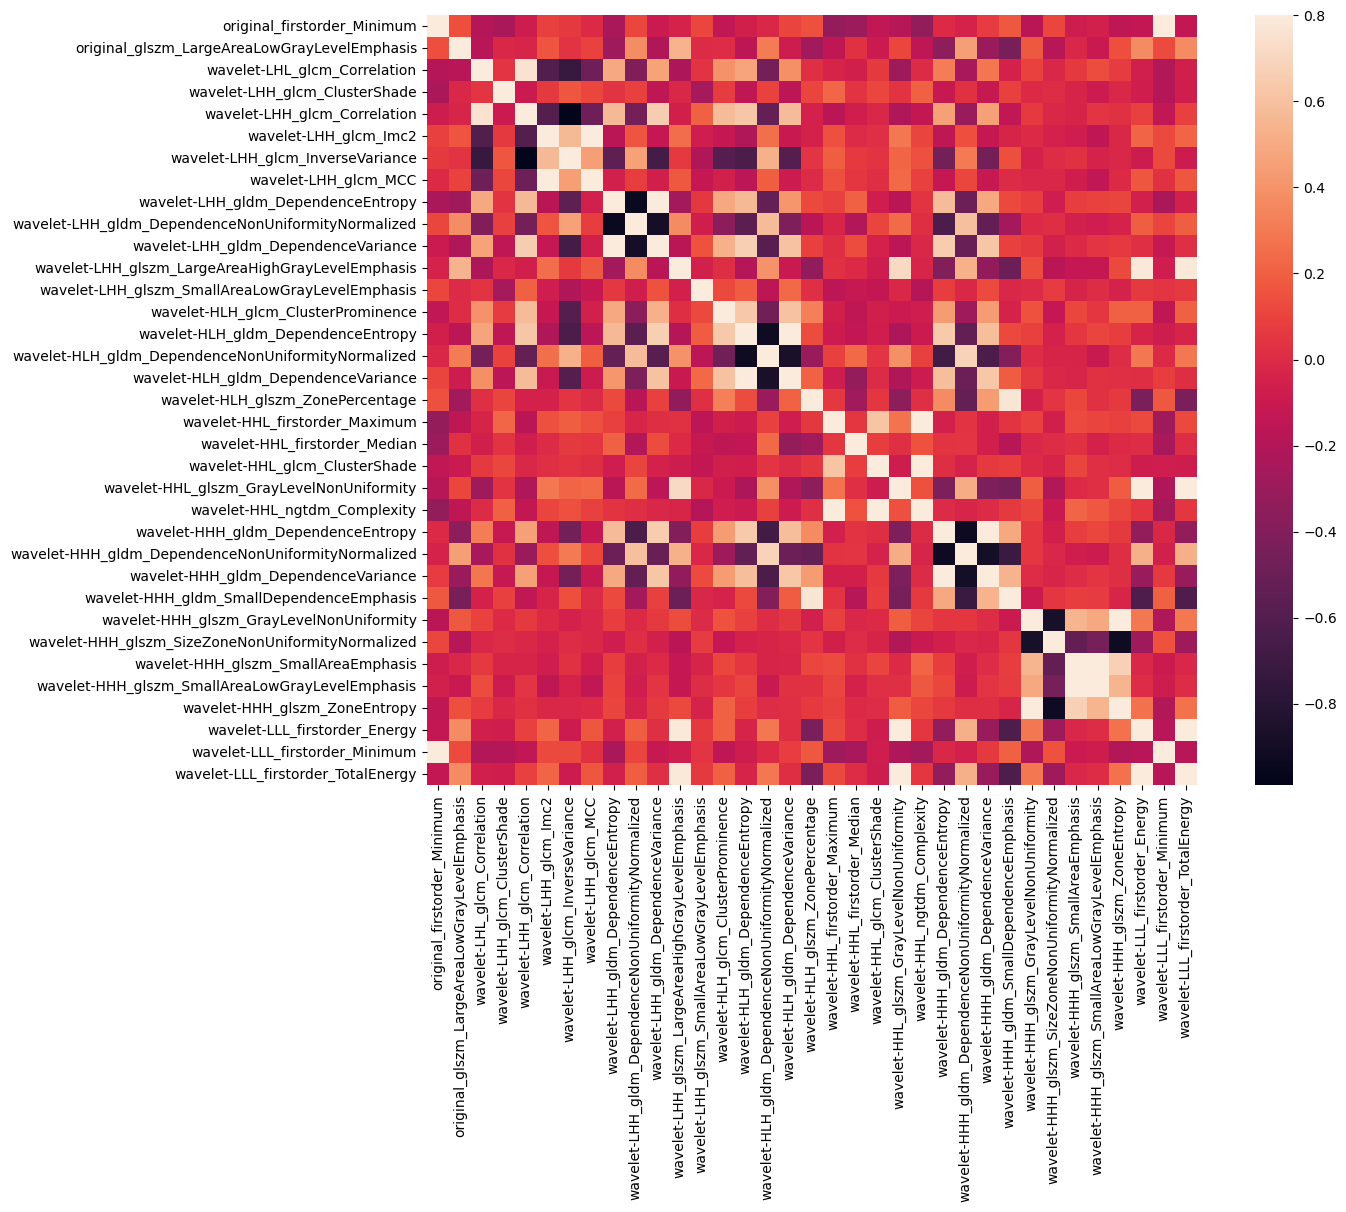

In [60]:
# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=features_df, columns=related_features_name)
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

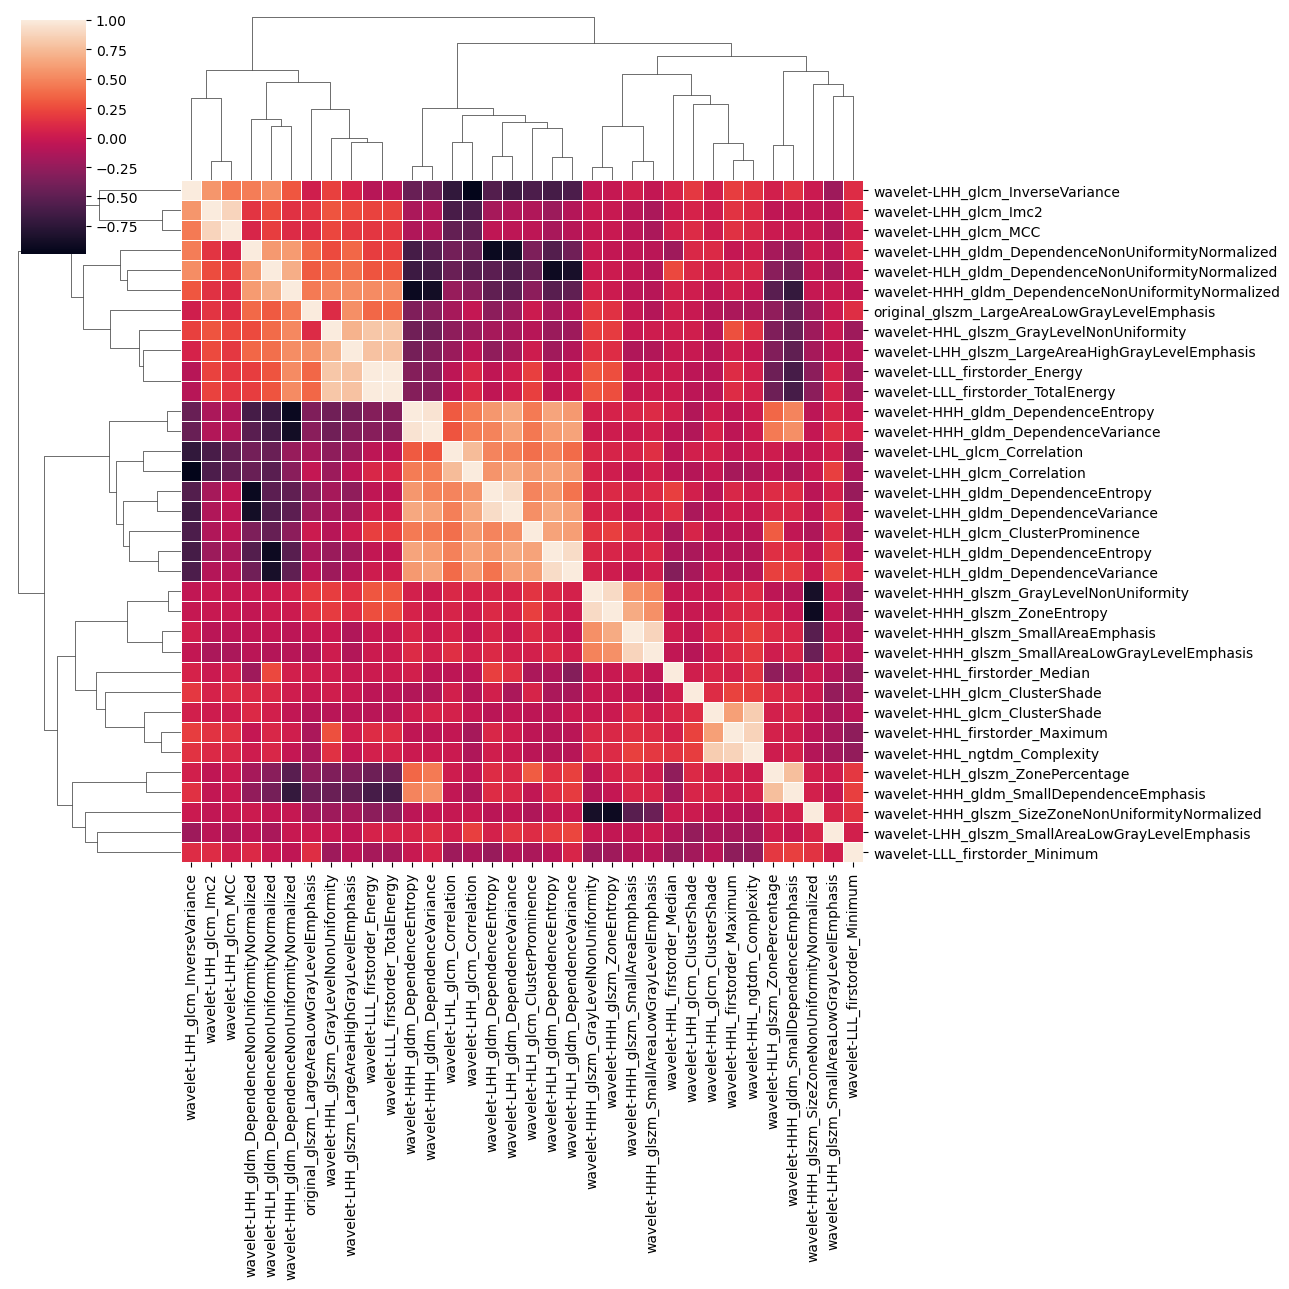

In [91]:
dd = d.iloc[:,1:50]
pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(13,13))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

### 4.2 多重共线性检测

In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 当VIF<10,说明不存在多重共线性；当10<=VIF<100,存在较强的多重共线性，当VIF>=100,存在严重多重共线性
vif = [variance_inflation_factor(XX.values, XX.columns.get_loc(i)) for i in XX.columns]

/Users/shipingguo/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [106]:
print('before vif check: ' + str(len(related_features_name)))
features_vif = []
for i in range(len(vif)):
    if vif[i]<10:
        features_vif.append(related_features_name[i])
print('after vif check: ' + str(len(features_vif)))

XXX = features_df[features_vif]


before vif check: 35
after vif check: 18


In [107]:
# 最终想要的18个特征
features_vif

['original_glszm_LargeAreaLowGrayLevelEmphasis',
 'wavelet-LHL_glcm_Correlation',
 'wavelet-LHH_glcm_ClusterShade',
 'wavelet-LHH_glcm_Imc2',
 'wavelet-LHH_glcm_MCC',
 'wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis',
 'wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis',
 'wavelet-HLH_glcm_ClusterProminence',
 'wavelet-HLH_glszm_ZonePercentage',
 'wavelet-HHL_firstorder_Maximum',
 'wavelet-HHL_firstorder_Median',
 'wavelet-HHL_glcm_ClusterShade',
 'wavelet-HHL_glszm_GrayLevelNonUniformity',
 'wavelet-HHH_gldm_SmallDependenceEmphasis',
 'wavelet-HHH_glszm_GrayLevelNonUniformity',
 'wavelet-HHH_glszm_SizeZoneNonUniformityNormalized',
 'wavelet-HHH_glszm_SmallAreaEmphasis',
 'wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis']

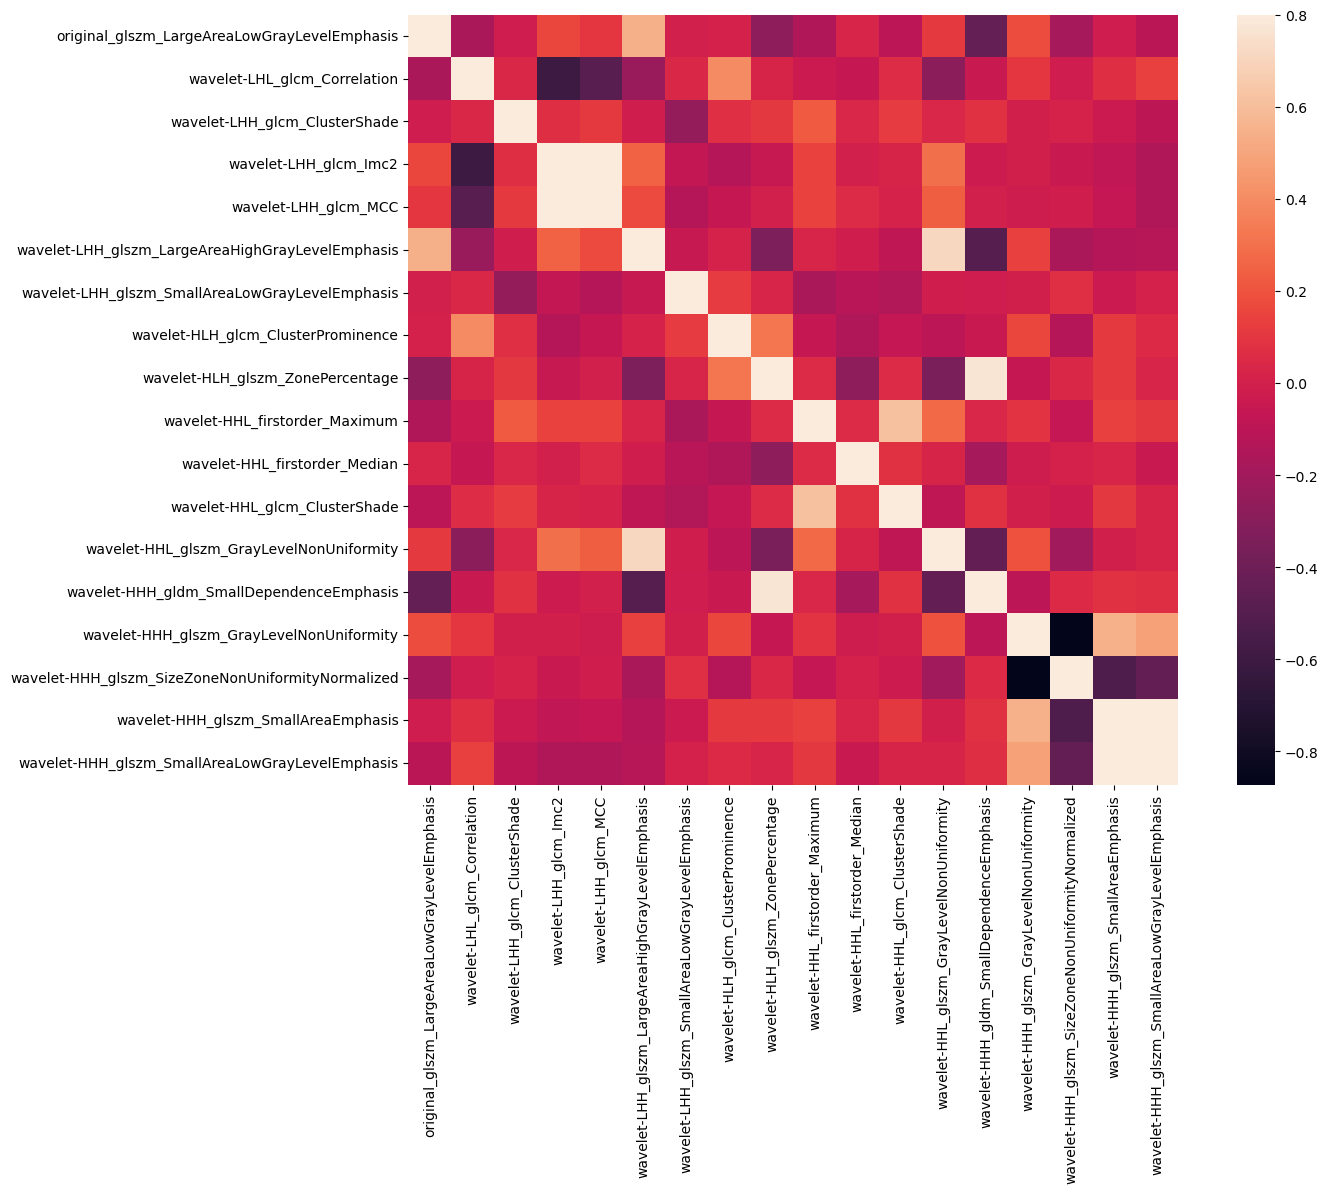

In [103]:
# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=features_df, columns=features_vif)
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

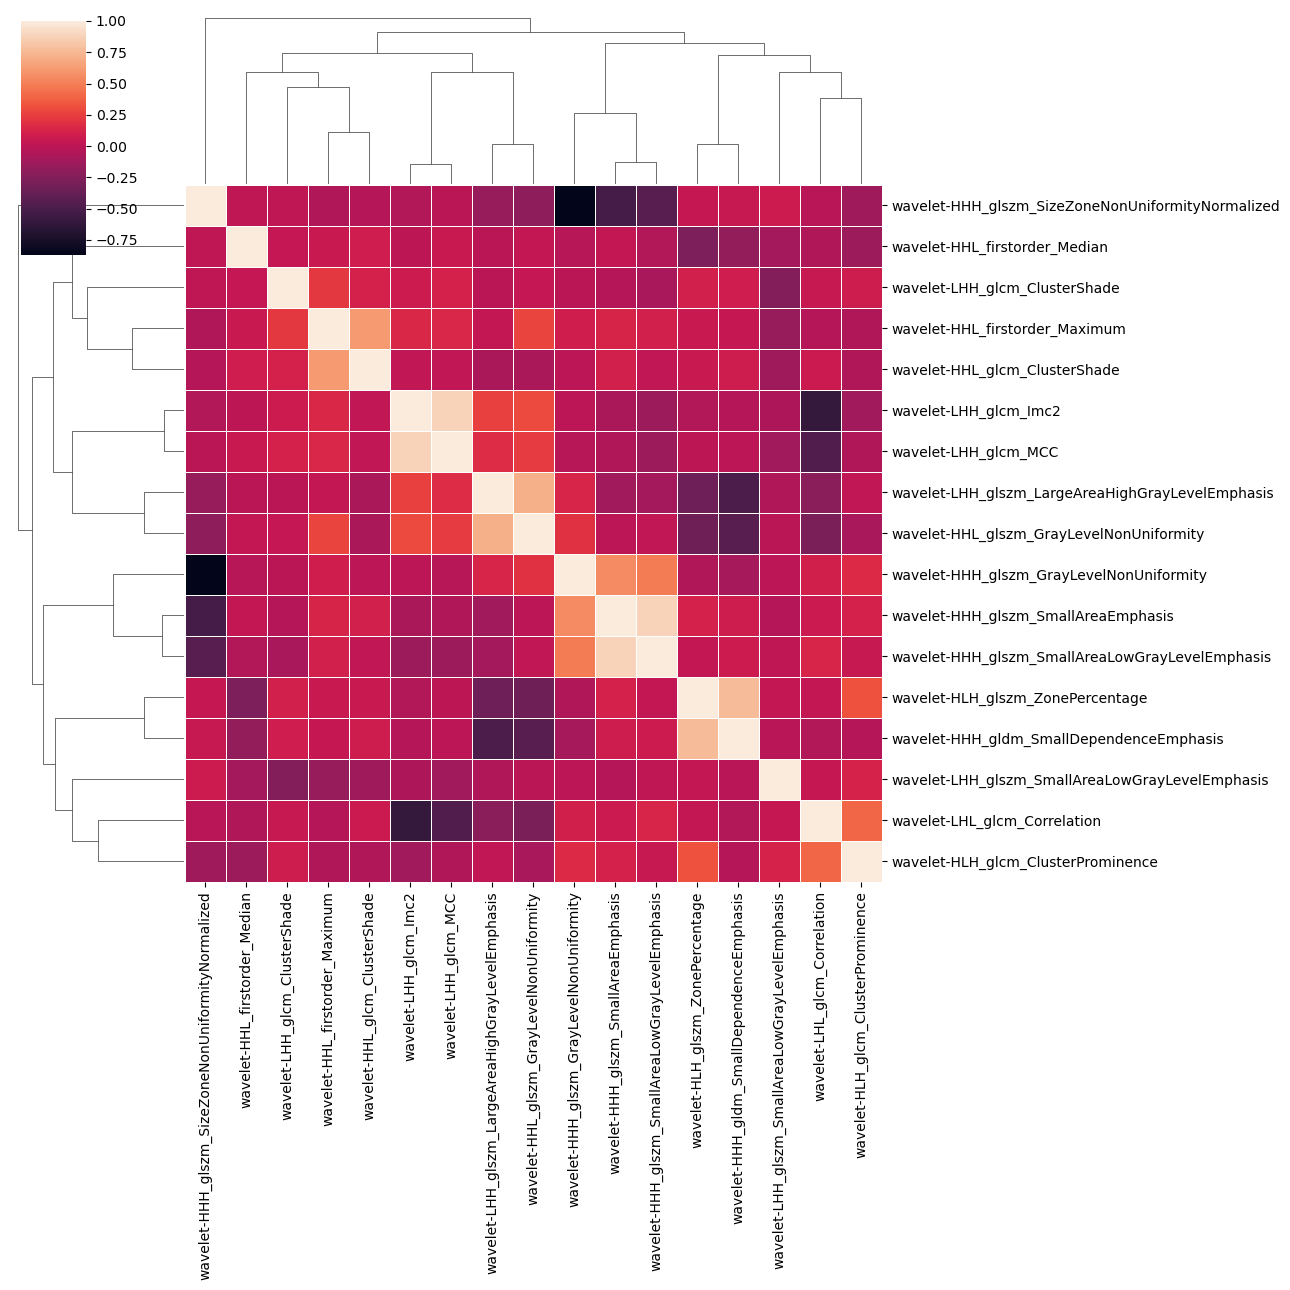

In [104]:
dd = d.iloc[:,1:50]
pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(13,13))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [63]:
len(features_vif)

18

In [108]:
# 将降维后的结果
X_train, X_test, Y_train, Y_test = train_test_split(XX, Y, test_size=0.15, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
classification_report_str = classification_report(Y_test, Y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)


Accuracy: 0.9
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       0.00      0.00      0.00         2

    accuracy                           0.90        20
   macro avg       0.45      0.50      0.47        20
weighted avg       0.81      0.90      0.85        20



/Users/shipingguo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shipingguo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shipingguo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4.3 PCA降维

In [65]:
def pca(data, n_dim):
    '''
    pca is O(D^3)
    :param data: (n_samples, n_features(D))
    :param n_dim: target dimensions
    :return: (n_samples, n_dim)
    '''
    data = data - np.mean(data, axis = 0, keepdims = True)
    cov = np.dot(data.T, data)
    eig_values, eig_vector = np.linalg.eig(cov)
    # print(eig_values)
    indexs_ = np.argsort(-eig_values)[:n_dim]
    picked_eig_values = eig_values[indexs_]
    picked_eig_vector = eig_vector[:, indexs_]
    data_ndim = np.dot(data, picked_eig_vector)
    return data_ndim

In [66]:
feature_pca3 = pca(X, 3)
feature_pca3.shape

(132, 3)

/Users/shipingguo/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/shipingguo/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/shipingguo/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/shipingguo/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/shipingguo/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets

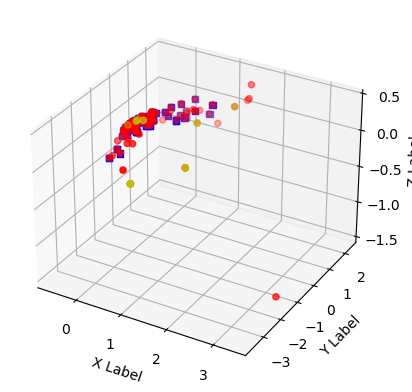

In [67]:
import random
random_numbers = [random.randint(0, 131) for _ in range(len(Y))]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(feature_pca3[:, 0], feature_pca3[:, 1], feature_pca3[:, 2], c='r', marker='o')
ax.scatter(np.array(feature_pca3[random_numbers, 0])[np.array(Y[random_numbers]) == 0],
           np.array(feature_pca3[random_numbers, 1])[np.array(Y[random_numbers]) == 0],
           np.array(feature_pca3[random_numbers, 2])[np.array(Y[random_numbers]) == 0],
           c='b', marker='s', label='Group 1')

# Scatter plot for the second group (color_column == 1)
ax.scatter(np.array(feature_pca3[random_numbers, 0])[np.array(Y[random_numbers]) == 1],
           np.array(feature_pca3[random_numbers, 1])[np.array(Y[random_numbers]) == 1],
           np.array(feature_pca3[random_numbers, 2])[np.array(Y[random_numbers]) == 1],
           c='y', marker='o', label='Group 2')
# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()

### 4.4 查看一下在现有的数据上哪种分类表现的比较好

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [69]:
model_score = np.zeros([30, 5])

for i in range(30):
    X_train, X_test, Y_train, Y_test = train_test_split(XXX, Y, test_size=0.2, random_state=42)
    # 随机森林模型
    model1 = RandomForestClassifier()
    model1.fit(X_train, Y_train)
    Y_pred1 = model1.predict(X_test)
    model_score[i, 0] = accuracy_score(Y_test, Y_pred1)

    model2 = GradientBoostingClassifier()
    model2.fit(X_train, Y_train)
    Y_pred2 = model2.predict(X_test)
    model_score[i, 1] = accuracy_score(Y_test, Y_pred2)

    model4 = DecisionTreeClassifier()
    model4.fit(X_train, Y_train)
    Y_pred4 = model4.predict(X_test)
    model_score[i, 2] = accuracy_score(Y_test, Y_pred4)

    model5 = SVC()
    model5.fit(X_train, Y_train)
    Y_pred5 = model5.predict(X_test)
    model_score[i, 3] = accuracy_score(Y_test, Y_pred5)

    model6 = MLPClassifier()
    model6.fit(X_train, Y_train)
    Y_pred6 = model6.predict(X_test)
    model_score[i, 4] = accuracy_score(Y_test, Y_pred6)

In [70]:
print("Random forest: " + str(sum(model_score[:, 0])/30) )
print("Gradient Boosting: " + str(sum(model_score[:, 1])/30) )
print("Decision Tree: " + str(sum(model_score[:, 2])/30) )
print("SVC: " + str(sum(model_score[:, 3])/30) )
print("MLP: " + str(sum(model_score[:, 4])/30) )

Random forest: 0.9135802469135806
Gradient Boosting: 0.7654320987654322
Decision Tree: 0.7111111111111111
SVC: 0.8518518518518514
MLP: 0.6555555555555556


随机森林的效果比较好

下面以随机森林和支持向量机来判断哪一个降维的效果比较好

In [71]:
accuracy_list = []
for i in range(2, 150, 2):
    feature_pca = pca(X, i)
    temp_accuracy = 0
    for j in range(10):
        X_train, X_test, Y_train, Y_test = train_test_split(np.real(feature_pca), Y, test_size=0.2, random_state=42)
        # 初始化随机森林模型
        model1 = RandomForestClassifier()
        model1.fit(X_train, Y_train)
        Y_pred = model1.predict(X_test)
        accuracy1 = accuracy_score(Y_test, Y_pred)
        # SVC
        model2 = SVC()
        model2.fit(X_train, Y_train)
        Y_pred = model2.predict(X_test)
        accuracy2 = accuracy_score(Y_test, Y_pred)
        accuracy = (accuracy1 + accuracy2)/2
        temp_accuracy = temp_accuracy + accuracy
    accuracy_list.append(temp_accuracy)    


In [72]:
# 找一下PCA降维哪个维度比较合适
for i in range(len(accuracy_list)):
    if accuracy_list[i]/10 > 0.85:
        print("Dimentions:"+ str(2+5*i))

Dimentions:17
Dimentions:62
Dimentions:77
Dimentions:82
Dimentions:87
Dimentions:97
Dimentions:102
Dimentions:107
Dimentions:112
Dimentions:117
Dimentions:122
Dimentions:127
Dimentions:132
Dimentions:137
Dimentions:142
Dimentions:147
Dimentions:152
Dimentions:157
Dimentions:162
Dimentions:167
Dimentions:172
Dimentions:177
Dimentions:182
Dimentions:187
Dimentions:192
Dimentions:197
Dimentions:202
Dimentions:207
Dimentions:212
Dimentions:217
Dimentions:222
Dimentions:227
Dimentions:232
Dimentions:237
Dimentions:242
Dimentions:247
Dimentions:252
Dimentions:257
Dimentions:262
Dimentions:267
Dimentions:272
Dimentions:277
Dimentions:282
Dimentions:287
Dimentions:292
Dimentions:297
Dimentions:302
Dimentions:307
Dimentions:312
Dimentions:317
Dimentions:322
Dimentions:327
Dimentions:332
Dimentions:337
Dimentions:342
Dimentions:347
Dimentions:352
Dimentions:357
Dimentions:362
Dimentions:367


在维度比较低的时候准确率比较高

### 4.5 对比一下t检验和PCA降维

In [73]:
t_model_score = []
#feature_pca = highdim_pca(X, 300)
# 测30次看平均准确率
for i in range(30):
    X_train, X_test, Y_train, Y_test = train_test_split(XXX, Y, test_size=0.2, random_state=42)
    # 随机森林模型
    model1 = RandomForestClassifier()
    model1.fit(X_train, Y_train)
    Y_pred1 = model1.predict(X_test)
    t_model_score.append(accuracy_score(Y_test, Y_pred1))

In [74]:
sum(t_model_score)/30

0.9135802469135808

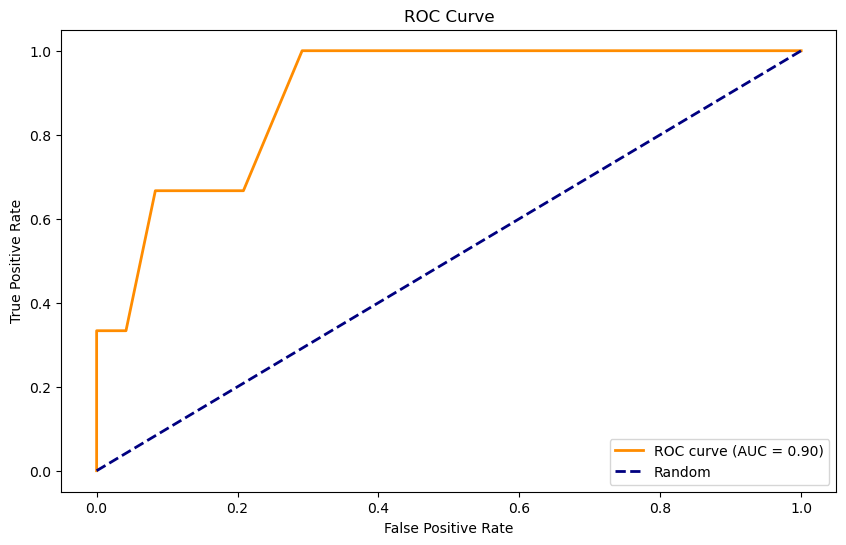

In [75]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_pred_proba = model1.predict_proba(X_test)[:, 1]
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

PCA降维的结果并不怎么理想

# Part 5. 探索一下提取更多特征看效果是否有提升

In [76]:
def catch_features(imagePath, maskPath):
    if imagePath is None or maskPath is None:  # Something went wrong, in this case PyRadiomics will also log an error
        raise Exception('Error getting testcase!')  # Raise exception to prevent cells below from running in case of "run all"
    settings = {}
    settings['binWidth'] = 25  # 5
    settings['sigma'] = [3, 5]
    settings['Interpolator'] = sitk.sitkBSpline
    settings['resampledPixelSpacing'] = [1, 1, 1]  # 3,3,3
    settings['voxelArrayShift'] = 1000  # 300
    settings['normalize'] = True
    settings['normalizeScale'] = 100
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

    extractor.enableImageTypeByName('LoG')
    extractor.enableImageTypeByName('Wavelet')
    extractor.enableAllImageTypes()
    extractor.enableAllFeatures()
    extractor.enableFeatureClassByName('firstorder')

    feature_cur = []
    feature_name = []
    result = extractor.execute(imagePath, maskPath, label=1)
    for key, value in six.iteritems(result):
        feature_name.append(key)
        feature_cur.append(value)
    
    name = feature_name[37:]
    name = np.array(name)
    for i in range(len(feature_cur[37:])):
        #if type(feature_cur[i+22]) != type(feature_cur[30]):
        feature_cur[i+37] = float(feature_cur[i+37])
    return feature_cur[37:], name

In [77]:
# Test codes
imagePath = '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_0_0000.nii'
maskPath = '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_0.nii'
feature_name, feature_cur = catch_features(imagePath, maskPath)

parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

In [78]:
feature_N2 = len(feature_name)


In [79]:
save_file2 = np.empty(shape=[1, feature_N2])


In [80]:
save_file2 = np.delete(save_file2, 0,  0)


In [81]:
save_file2

array([], shape=(0, 1595), dtype=float64)

1595个特征，然后用同样的方式分类查看准确率

In [82]:
for patient_index in range (len(IMAGE_LIST)):
    # print("Images:" + images_list[patient_index])
    # print("Masks:" + masks_list[patient_index])   

    imagePath = os.path.join(imagesTr_normalized, IMAGE_LIST_NII[patient_index])
    maskPath = os.path.join(labelsTr_nii, LABEL_LIST_NII[patient_index])
    print(imagePath)
    print(maskPath)
    
    save_curdata, features_name = catch_features(imagePath, maskPath)
    # print(len(save_curdata))
    save_curdata = np.array(save_curdata)
    save_curdata = save_curdata.reshape([1, feature_N2])
    # id.append(PRE_IMAGE_LIST[patient_index].split('.')[0])        # Don't need ID
    # print(save_curdata)
    # print(images_list[patient_index])
    #np.concatenate((images_list[patient_index], save_curdata),axis=1)
    save_file2 = np.append(save_file2, save_curdata, axis=0)
    # print(save_file.shape)


/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_0_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_0.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_1_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_1.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_2_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_2.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_3_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_3.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_4_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_4.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_5_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_5.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_6_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_6.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_7_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_7.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_8_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_8.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_9_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_9.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_10_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_10.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_11_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_11.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_12_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_12.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_13_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_13.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_14_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_14.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_15_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_15.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_16_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_16.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_17_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_17.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_18_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_18.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_19_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_19.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_20_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_20.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_21_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_21.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_22_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_22.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_24_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_24.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_25_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_25.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_26_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_26.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Calculating Local Binary Pattern in 2D, but extracting featu

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_29_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_29.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_31_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_31.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_32_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_32.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_33_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_33.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_34_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_34.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_35_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_35.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_36_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_36.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_37_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_37.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_38_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_38.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_39_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_39.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_40_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_40.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_41_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_41.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_42_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_42.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_43_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_43.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_45_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_45.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_48_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_48.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_50_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_50.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_51_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_51.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_52_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_52.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_54_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_54.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_56_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_56.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_57_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_57.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_59_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_59.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_60_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_60.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_61_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_61.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_62_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_62.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_63_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_63.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_64_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_64.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_66_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_66.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_67_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_67.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_69_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_69.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_70_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_70.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_71_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_71.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_72_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_72.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_73_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_73.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_74_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_74.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_75_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_75.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_76_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_76.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_77_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_77.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_79_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_79.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_81_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_81.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_83_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_83.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_84_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_84.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_86_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_86.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_87_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_87.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_89_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_89.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_90_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_90.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_91_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_91.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_92_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_92.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_93_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_93.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_94_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_94.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_95_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_95.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_96_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_96.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_97_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_97.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_98_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_98.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_99_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_99.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_100_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_100.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_101_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_101.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Calculating Local Binary Pattern in 2D, but extracting features in 3D. Use with caution!
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, o

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_102_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_102.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_103_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_103.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_104_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_104.nii


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_105_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_105.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_106_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_106.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_107_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_107.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_109_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_109.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_110_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_110.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_111_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_111.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_112_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_112.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_113_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_113.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_114_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_114.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_117_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_117.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_118_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_118.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_119_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_119.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_120_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_120.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_121_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_121.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_122_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_122.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_123_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_123.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_124_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_124.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_125_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_125.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_126_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_126.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_127_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_127.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_128_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_128.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_129_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_129.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_130_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_130.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_131_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_131.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_132_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_132.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_133_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_133.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_134_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_134.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_135_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_135.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_136_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_136.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_137_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_137.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_138_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_138.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_139_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_139.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_140_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_140.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_141_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_141.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_142_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_142.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_143_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_143.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_145_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_145.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_146_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_146.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_147_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_147.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_151_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_151.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_152_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_152.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_153_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_153.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_154_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_154.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_155_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_155.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/imagesTr_normalized/Pituitarytumor_156_0000.nii
/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer/labelsTr_nii/Pituitarytumor_156.nii


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calc

In [83]:
# save_file = np.delete(save_file, 0,  0)
# save_file = save_file.transpose()
# print(save_file.shape)
# id_num = len(id)
# id = np.array(id)
features_df2 = pd.DataFrame(save_file2)
# name_df.index = id
features_df2.columns = features_name
features_df2['Class'] = class_list
features_df2 = features_df2.reset_index(drop=True)

export_dir = '/Users/shipingguo/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Pituitary-segmentation-and-classification-/1_Classifer'
# parent_directory = os.path.dirname(export_dir)
features_xlsx = os.path.join(export_dir, 'Radiomics-features2.xlsx')
writer = pd.ExcelWriter(features_xlsx)
features_df2.to_excel(writer)
writer.save()

/var/folders/53/tlbwbq3n5lz3nsqwqwk1p30w0000gn/T/ipykernel_16576/3477453624.py:17: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [84]:
X_2 = features_df2.iloc[:, 0:-1].values  # we only take the first two features.
Y_2 = features_df2['Class']
columns = features_df2.columns
related_features_name = []
print('Related features:')
for column in columns[0:-1]:
    t_score = t_test('Class', column, features_df2)
    if t_score<0.1:
        related_features_name.append(column)
        print(column)

Related features:
original_firstorder_Minimum
original_glszm_LargeAreaLowGrayLevelEmphasis
log-sigma-3-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis
log-sigma-5-mm-3D_gldm_DependenceNonUniformityNormalized
wavelet-LHL_glcm_Correlation
wavelet-LHH_glcm_ClusterShade
wavelet-LHH_glcm_Correlation
wavelet-LHH_glcm_Imc2
wavelet-LHH_glcm_InverseVariance
wavelet-LHH_glcm_MCC
wavelet-LHH_gldm_DependenceEntropy
wavelet-LHH_gldm_DependenceNonUniformityNormalized
wavelet-LHH_gldm_DependenceVariance
wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis
wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis
wavelet-HLH_glcm_ClusterProminence
wavelet-HLH_gldm_DependenceEntropy
wavelet-HLH_gldm_DependenceNonUniformityNormalized
wavelet-HLH_gldm_DependenceVariance
wavelet-HLH_glszm_ZonePercentage
wavelet-HHL_firstorder_Maximum
wavelet-HHL_firstorder_Median
wavelet-HHL_glcm_ClusterShade
wavelet-HHL_glszm_GrayLevelNonUniformity
wavelet-HHL_ngtdm_Complexity
wavelet-HHH_gldm_DependenceEntropy
wavelet-HHH_gldm_DependenceNon

/var/folders/53/tlbwbq3n5lz3nsqwqwk1p30w0000gn/T/ipykernel_16576/967509918.py:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p_t = ttest_ind(type_one, type_two)
/Users/shipingguo/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/var/folders/53/tlbwbq3n5lz3nsqwqwk1p30w0000gn/T/ipykernel_16576/967509918.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p_t = ttest_ind(type_one, type_two, equal_var=False)


In [85]:
len(related_features_name)

60

In [86]:
XX_2 = features_df2[related_features_name]
vif = [variance_inflation_factor(XX_2.values, XX_2.columns.get_loc(i)) for i in XX_2.columns]

/Users/shipingguo/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [87]:
print(len(related_features_name))
features_vif = []
for i in range(len(vif)):
    if vif[i]<10:
        features_vif.append(related_features_name[i])
print(len(features_vif))

XXX_2 = features_df2[features_vif]

60
24


In [88]:
t_model_score = []
#feature_pca = highdim_pca(X, 300)

for i in range(30):
    X_train, X_test, Y_train, Y_test = train_test_split(XXX_2, Y_2, test_size=0.2, random_state=42)
    # 随机森林模型
    model1 = RandomForestClassifier()
    model1.fit(X_train, Y_train)
    Y_pred1 = model1.predict(X_test)
    t_model_score.append(accuracy_score(Y_test, Y_pred1))

In [89]:
sum(t_model_score)/30

0.8703703703703703

效果并不理想，所以保持原来的特征与降维方式